In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pyreadr
import scanpy as sc
import seaborn as sns
from tmm import tmm_normalize

In [3]:
def plot_stacked_probs(probs, class_labels=None, sample_labels=None,
                       n_rows=1, figsize=(12, 6), save_path=None, title=None,
                       xlabel='Sample_cluster', sort_by_y=None, ax=None,
                       cmapping=None, renaming=None):
    """
    probs: (n_samples, n_classes) numpy array
    class_labels: list of class names (len = n_classes)
    sample_labels: list of sample names (len = n_samples)
    n_rows: number of rows in the subplot grid
    """
    n_samples, n_classes = probs.shape
    if class_labels is None:
        class_labels = [f"Class {i}" for i in range(n_classes)]
    if sample_labels is None:
        sample_labels = [f"S{i}" for i in range(n_samples)]
    if sort_by_y is not None:
        order = np.argsort(probs[:, sort_by_y])
        probs = probs[order]
        sample_labels = [sample_labels[i] for i in order]

    if renaming is not None:
        class_labels = [renaming.get(cls, cls) for cls in class_labels]
    
    # Compute grid
    if ax is None:
        n_cols = int(np.ceil(n_samples / n_rows))
        fig, axes = plt.subplots(n_rows, 1, figsize=figsize, gridspec_kw={'hspace':0.3},
                                sharey=True)
        if n_rows == 1:
            axes = np.array([axes])
        axes = axes.ravel()
    else:
        axes = np.array([ax])
        fig = plt.gcf()
        n_rows = 1
        n_cols = int(np.ceil(n_samples / n_rows))

    # Colors
    if cmapping is not None:
        colors = [cmapping[cls] for cls in class_labels]
    else:
        cmap = plt.cm.get_cmap("tab20", n_classes)
        colors = [cmap(i) for i in range(n_classes)]

    # Split samples evenly among rows
    for i in range(n_rows):
        start = i * n_cols
        end = min((i + 1) * n_cols, n_samples)
        ax = axes[i]
        bottom = np.zeros(end - start)

        for j in range(n_classes):
            ax.bar(range(start, end), probs[start:end, j],
                   bottom=bottom, color=colors[j], label=class_labels[j])
            bottom += probs[start:end, j]

        ax.set_xticks(range(start, end))
        ax.set_xticklabels(sample_labels[start:end], rotation=90, fontsize=8)
        if i == 0:  # only put legend once
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)

        ax.set_ylim(0, 1.0)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_ylabel('Predicted probability', fontsize=14)
    axes[-1].set_xlabel(xlabel, fontsize=14)
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    if title is not None:
        axes[0].set_title(title, fontsize=14)
    return fig, axes

In [4]:
pseudobulks_dir = '/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out'
atac_pseudobulks_normed = pyreadr.read_r(f'{pseudobulks_dir}/luas_sample_log2cpm_jointTMMwsp.rds')[None].T

In [5]:
def subset_peaks(exp_df, peaks):
    return exp_df.reindex(columns=peaks, fill_value=0)

/tmp/ipykernel_2255537/416626984.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_classes)


(<Figure size 1200x400 with 1 Axes>,
 array([<Axes: title={'center': 'LUAS sample ATAC predictions'}, ylabel='Predicted probability'>],
       dtype=object))

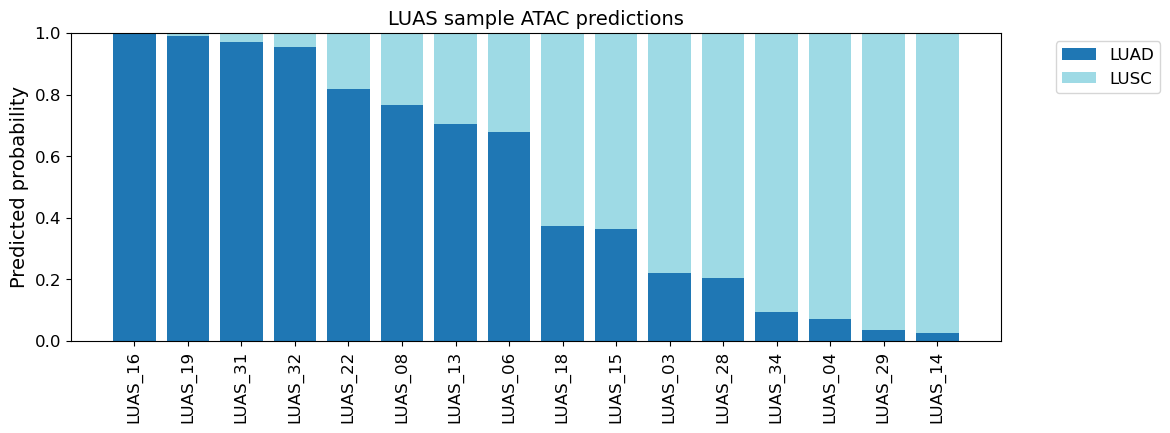

In [6]:
peak_set = 'hvp_50000'
C = 0.001
model_dir = f'/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out/log_reg/luad_vs_lusc_{peak_set}'
with open(f'{model_dir}/models.pkl', 'rb') as f:
    models = pickle.load(f)
atac_model = models[C]
peaks = atac_model.feature_names_in_
X = subset_peaks(atac_pseudobulks_normed, peaks)
atac_pseudobulk_probs = atac_model.predict_proba(X)
plot_stacked_probs(atac_pseudobulk_probs, class_labels=atac_model.classes_, sample_labels=atac_pseudobulks_normed.index,
                   n_rows=1, figsize=(12, 4), save_path=None, xlabel='',
                   title=f'LUAS sample ATAC predictions', sort_by_y=1)

In [7]:
def subset_genes(exp_df, genes):
    return exp_df.reindex(columns=genes, fill_value=0)

pseudobulks_dir = '/data1/chanj3/LUAS.multiome.results/TCGA_expression_modeling/out'
pseudobulks_raw = np.load(f'{pseudobulks_dir}/rna_sample_pseudobulks_raw.npy')
pseudobulk_genes = pd.read_csv(f'{pseudobulks_dir}/rna_sample_pseudobulk_genes.txt', header=None).iloc[:, 0].values
pseudobulk_labels = pd.read_csv(f'{pseudobulks_dir}/rna_sample_pseudobulk_labels.txt', header=None).iloc[:, 0].values
pseudobulks_raw = pd.DataFrame(pseudobulks_raw, index=pseudobulk_labels, columns=pseudobulk_genes)
rna_pseudobulks_normed = tmm_normalize(pseudobulks_raw.T).T

/tmp/ipykernel_2255537/416626984.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_classes)


(<Figure size 1200x400 with 1 Axes>,
 array([<Axes: title={'center': 'LUAS sample RNA predictions'}, xlabel='Sample', ylabel='Predicted probability'>],
       dtype=object))

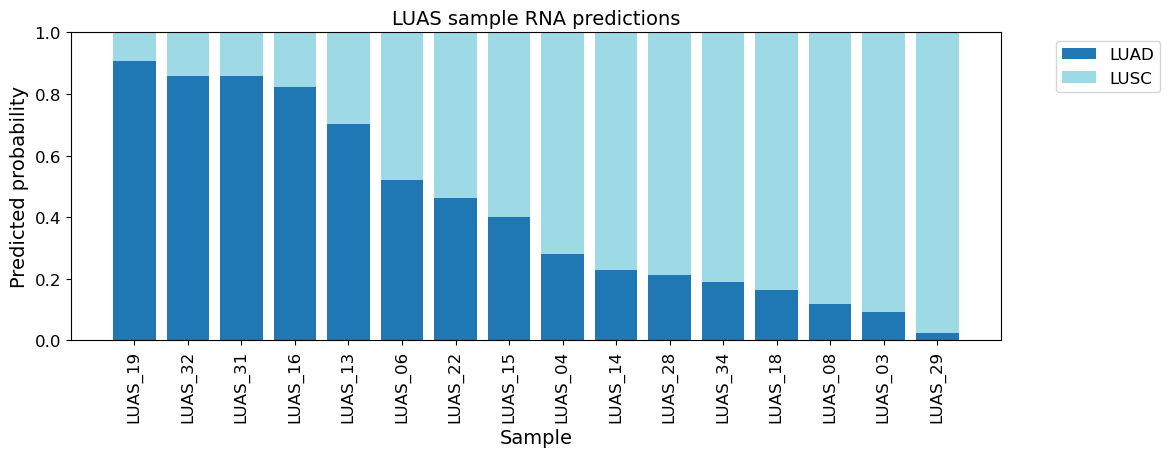

In [8]:
import os
gene_set = 'max_fdr_1e-6_min_logfc_2_top_200_per'
C = 0.001

model_dir = f'/data1/chanj3/LUAS.multiome.results/TCGA_expression_modeling/out/log_reg/luad_vs_lusc_{gene_set}'
with open(f'{model_dir}/models.pkl', 'rb') as f:
    models = pickle.load(f)
rna_model = models[C]
genes = rna_model.feature_names_in_
X = subset_genes(rna_pseudobulks_normed, genes)
rna_pseudobulk_probs = rna_model.predict_proba(X)
plot_stacked_probs(rna_pseudobulk_probs, class_labels=rna_model.classes_, sample_labels=rna_pseudobulks_normed.index,
                   n_rows=1, figsize=(12, 4), save_path=None, xlabel='Sample',
                   title=f'LUAS sample RNA predictions', sort_by_y=1)

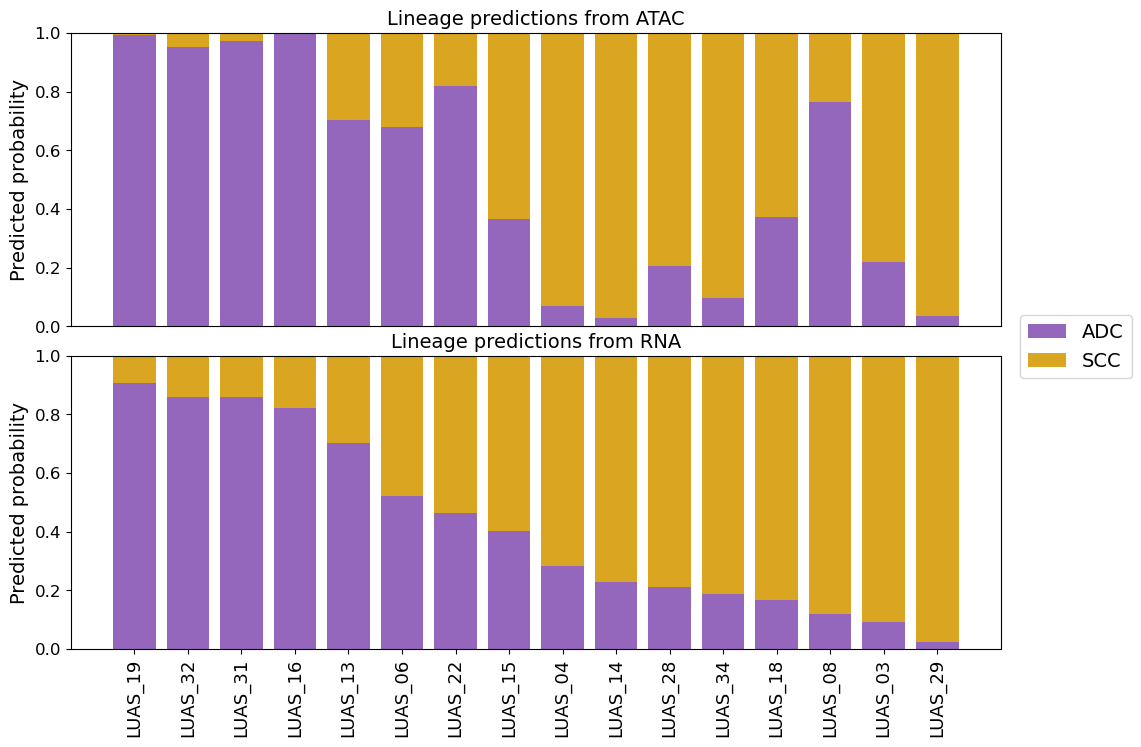

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.1})
cmapping = {'ADC': 'C4', 'SCC': 'goldenrod'}
ctype_renaming = {'LUAD': 'ADC', 'LUSC': 'SCC'}
order = np.argsort(rna_pseudobulk_probs[:, 1])
plot_stacked_probs(atac_pseudobulk_probs[order], class_labels=atac_model.classes_, sample_labels=atac_pseudobulks_normed.index[order],
                   n_rows=1, figsize=(12, 4), save_path=None, xlabel='', title='Lineage predictions from ATAC', ax=axes[0], cmapping=cmapping,
                   renaming=ctype_renaming)
axes[0].set_ylabel('Predicted probability', fontsize=14)
axes[0].set_xticks([])
axes[0].get_legend().remove()
plot_stacked_probs(rna_pseudobulk_probs[order], class_labels=rna_model.classes_, sample_labels=rna_pseudobulks_normed.index[order],
                   n_rows=1, figsize=(12, 4), save_path=None, xlabel='', title='Lineage predictions from RNA', ax=axes[1], cmapping=cmapping,
                   renaming=ctype_renaming)
axes[1].set_ylabel('Predicted probability', fontsize=14)
axes[1].legend(bbox_to_anchor=(1.01, 1.03), loc="center left", fontsize=14)
axes[1].tick_params(axis='x', labelsize=13)
plt.show()

In [10]:
pseudobulks_dir = '/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out'
atac_cluster_pseudobulks_normed = pyreadr.read_r(f'{pseudobulks_dir}/luas_cluster_log2cpm_jointTMMwsp.rds')[None].T

pseudobulks_dir = ('/data1/chanj3/LUAS.multiome.results/epigenetic/accessibility_landscape'
                   '/v4/out/compare_vs_gorces')
pseudobulks_raw = np.load(f'{pseudobulks_dir}/rna_pseudobulks_raw.npy')
pseudobulk_genes = pd.read_csv(f'{pseudobulks_dir}/rna_pseudobulk_genes.txt', header=None).iloc[:, 0].values
pseudobulk_labels = pd.read_csv(f'{pseudobulks_dir}/rna_pseudobulk_labels.txt', header=None).iloc[:, 0].values
pseudobulks_raw = pd.DataFrame(pseudobulks_raw, index=pseudobulk_labels, columns=pseudobulk_genes)
rna_cluster_pseudobulks_normed = tmm_normalize(pseudobulks_raw.T).T

In [11]:
def comp_mean_r(mat, i0, i1):
    x = mat.iloc[i0].values
    y = mat.iloc[i1].values
    x = 2**x - 1
    y = 2**y - 1
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    m = np.log(x/y)
    order = np.argsort(m)
    c = int(0.15*len(m))
    return np.exp(np.mean(m[order[c:-c]]))
from itertools import combinations
pairs = list(combinations(range(len(rna_cluster_pseudobulks_normed)), 2))
random_pairs = [pairs[i] for i in np.random.choice(len(pairs), 10, replace=False)]
for i, j in random_pairs:
    print(comp_mean_r(rna_cluster_pseudobulks_normed, i, j))

0.9963023458469776
0.8504929041436774
0.8801045114924402
0.9706124558091034
1.022134845989013
1.0902007325506577
0.9473843090823917
0.9299764068583719
0.9279639831053015
0.9443781040546539


In [12]:
X = subset_genes(rna_cluster_pseudobulks_normed, genes)
rna_cluster_pseudobulk_probs = rna_model.predict_proba(X)

X = subset_peaks(atac_cluster_pseudobulks_normed, peaks)
atac_cluster_pseudobulk_probs = atac_model.predict_proba(X)

sample_nums = rna_pseudobulks_normed.index.str.split('_').str[1]
sample_num_vec = rna_cluster_pseudobulks_normed.index.str.split('_').str[0]

sample_num_to_prob = {a: b for a, b in zip(sample_nums, rna_pseudobulk_probs[:, 1])}

score_tuples = [(sample_num_to_prob[sn], p) for sn, p in zip(sample_num_vec, rna_cluster_pseudobulk_probs[:, 1])]
order = sorted(np.arange(len(score_tuples)), key=lambda i: score_tuples[i])

In [13]:
from matplotlib import patches

/tmp/ipykernel_2255537/1892500585.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_x))  # or any colormap


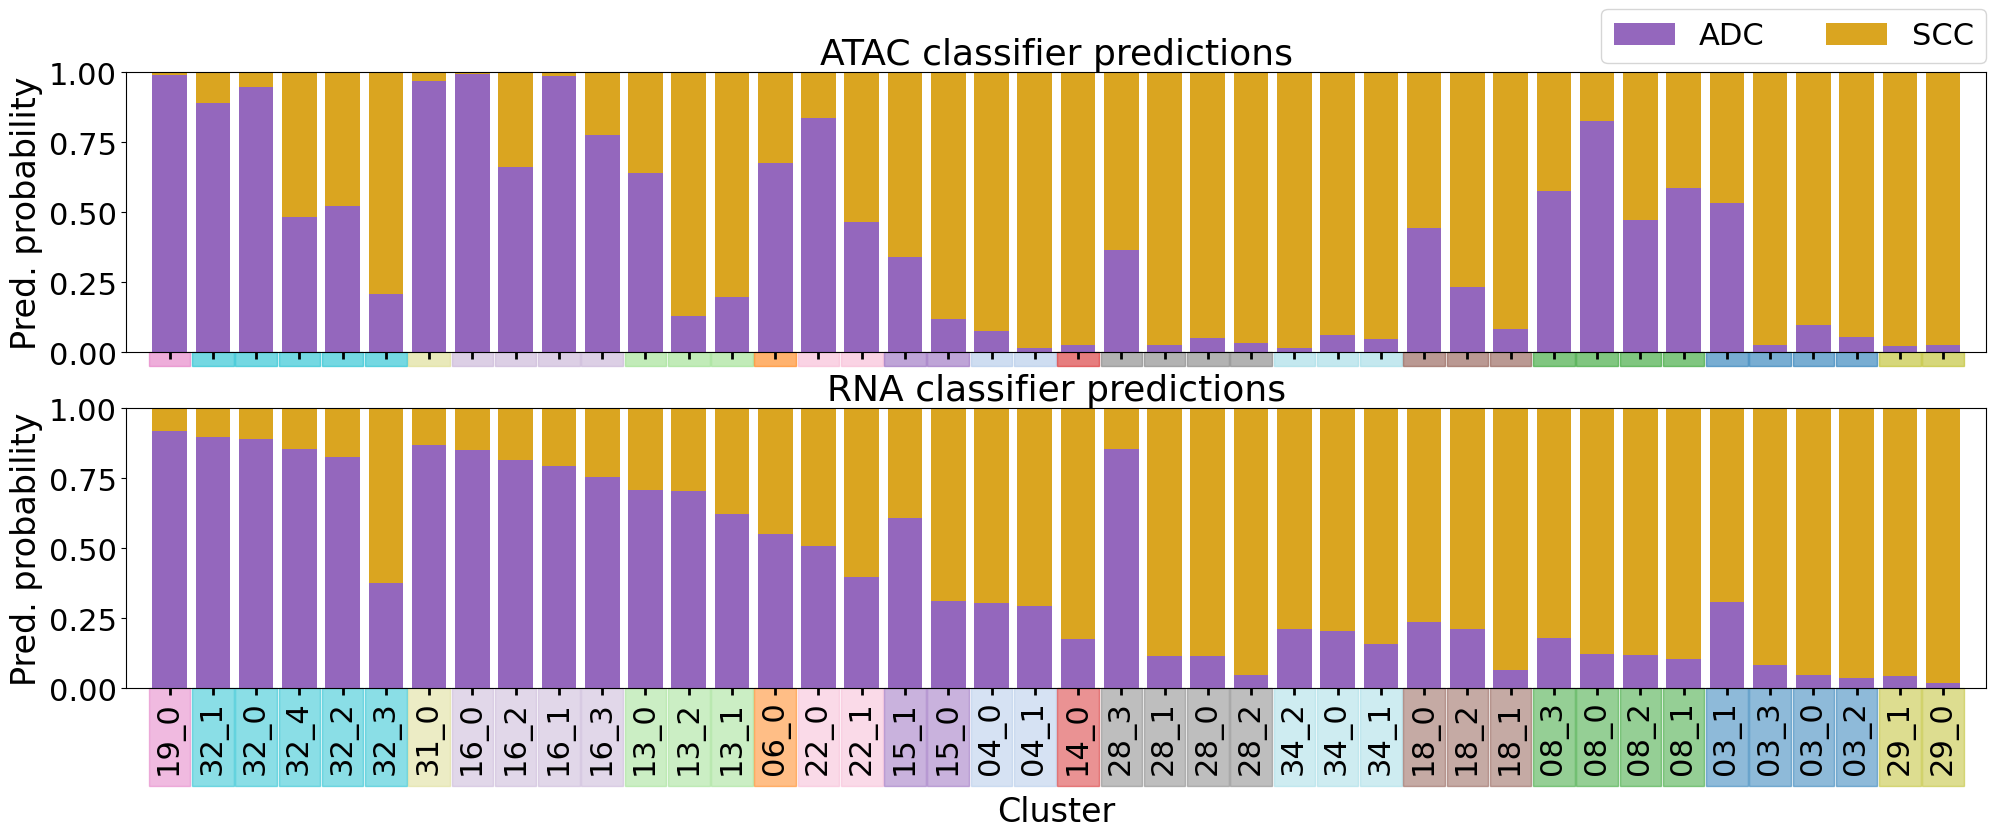

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8), gridspec_kw={'hspace': 0.2})
cmapping = {'ADC': 'C4', 'SCC': 'goldenrod'}
ctype_renaming = {'LUAD': 'ADC', 'LUSC': 'SCC'}
plot_stacked_probs(atac_cluster_pseudobulk_probs[order], class_labels=atac_model.classes_,
                   sample_labels=atac_cluster_pseudobulks_normed.index[order],
                   n_rows=1, figsize=(16, 4), save_path=None, xlabel='', title='ATAC classifier predictions', ax=axes[0],
                   cmapping=cmapping, renaming=ctype_renaming)
axes[0].set_ylabel('Pred. probability', fontsize=24)
axes[0].set_xticklabels([])
axes[0].get_legend().remove()
axes[0].set_title(axes[0].get_title(), fontsize=26)
plot_stacked_probs(rna_cluster_pseudobulk_probs[order], class_labels=rna_model.classes_,
                   sample_labels=rna_cluster_pseudobulks_normed.index[order], n_rows=1, figsize=(16, 4),
                   save_path=None, xlabel='', title='RNA classifier predictions', ax=axes[1], cmapping=cmapping,
                   renaming=ctype_renaming)
axes[1].set_title(axes[1].get_title(), fontsize=26)
axes[1].set_ylabel('Pred. probability', fontsize=24)
axes[1].legend(bbox_to_anchor=(1.008, 2.18), loc="lower right", fontsize=22, ncols=2)
for ax in axes:
    ax.tick_params(axis='both', labelsize=22)
    ax.tick_params(axis='x', size=5, width=2)

# Assign a color per unique 'x'
labels = rna_cluster_pseudobulks_normed.index
unique_x = sorted(set(label.split("_")[0] for label in labels))
cmap = plt.cm.get_cmap("tab20", len(unique_x))  # or any colormap
color_map = {x: cmap(i) for i, x in enumerate(unique_x)}

# Shade rectangles behind tick labels
ax0 = axes[0]
ax = axes[1]
ax.figure.canvas.draw()  # need layout info first
xticks = ax.get_xticks()
for tick, label in zip(xticks, ax.get_xticklabels()):
    x_str = label.get_text().split("_")[0]
    color = color_map[x_str]
    # Position: x coordinate in axis coords, y in display units
    bbox = label.get_window_extent(renderer=fig.canvas.get_renderer())
    bbox = bbox.transformed(ax.transData.inverted())  # convert to data coords

    # Rectangle under label
    inflate = 1.34
    x0 = bbox.x0 - (bbox.width)*(inflate - 1) / 2
    rect = patches.Rectangle(
        (x0, -0.35),   # (left, bottom)
        inflate*bbox.width, 0.35,   # (width, height)
        transform=ax.transData,
        color=color,
        alpha=0.5,
        zorder=-1,
        clip_on=False
    )
    ax.add_patch(rect)

    depth = 0.05
    rect = patches.Rectangle(
        (x0, -depth),   # (left, bottom)
        inflate*bbox.width, depth,   # (width, height)
        transform=ax0.transData,
        color=color,
        alpha=0.6,
        zorder=-1,
        clip_on=False
    )
    ax0.add_patch(rect)
axes[1].set_xlabel('Cluster', fontsize=24, labelpad=15)
for ax in axes:
    ax.set_xlim([-1, len(order)])
plt.show()

In [15]:
from adjustText import adjust_text
def scatterplot(df, x_name, y_name, ax, title='', legend=True, plot_texts=False,
                legend_loc=(1.02, 0.01), text_fontsize=10, adjust_text_expand=(1.25, 1.5),
                palette=None, force_pull=(0.01, 0.01), force_text=(0.1, 0.2),
                force_static=(0.1, 0.2), force_explode=(0.1, 0.5), s=80, hue=None):
    # Extract 'sample' from index
    df['sample'] = df.index.str.split('_').str[0]
    if hue is None:
        hue = 'sample'
        if palette is None:
            palette = 'tab20'
    else:
        palette = 'flare'
    sc = sns.scatterplot(
        data=df,
        x=x_name, 
        y=y_name, 
        hue=hue,
        palette=palette,
        s=s,
        ax=ax,
    )
    
    if plot_texts:
        texts = []
        for cluster, row in df.iterrows():
            texts.append(ax.text(row[x_name], row[y_name], cluster, fontsize=text_fontsize))
        
        # Pass scatter points to adjust_text so labels avoid them
        adjust_text(
            texts,
            ax=ax,
            add_objects=sc.collections,  # these are the scatter points
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
            expand=adjust_text_expand,
            force_pull=force_pull,
            force_text=force_text,
            force_static=force_static,
            force_explode=force_explode
        ) 

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(title)
    if legend:
        ax.legend(title='Sample', loc = legend_loc)
    else:
        ax.legend([])

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


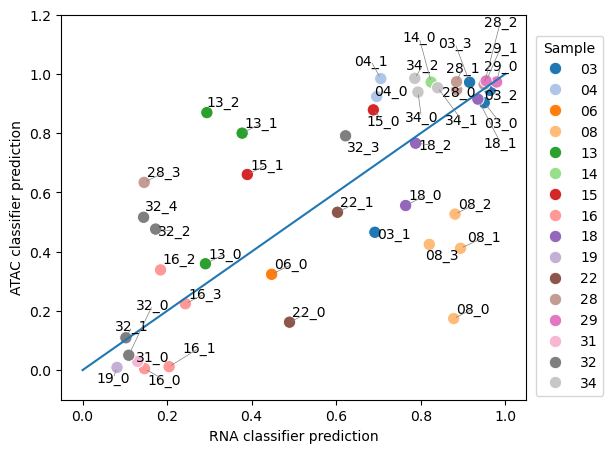

In [16]:
df = pd.DataFrame({'RNA classifier prediction': rna_cluster_pseudobulk_probs[:, 1], 'ATAC classifier prediction': atac_cluster_pseudobulk_probs[:, 1]},
                  index=rna_cluster_pseudobulks_normed.index)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_ylim(-0.1, 1.2)
scatterplot(df, x_name='RNA classifier prediction', y_name='ATAC classifier prediction', ax=ax, plot_texts=True)
ax.plot([0, 1], [0, 1])
plt.show()

In [17]:
#sc.settings.set_figure_params(figsize=(5, 5), dpi=150, fontsize=14)
adata = sc.read_h5ad('/data1/chanj3/LUAS.multiome.results/LUAS_tumor_rna_v4.h5ad')
adata = adata[adata.obs.sample_name.isin(rna_pseudobulks_normed.index)]
adata.obs['sample_num'] = adata.obs['sample_name'].str.split('_').str[1]

/tmp/ipykernel_2255537/4009335140.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample_num'] = adata.obs['sample_name'].str.split('_').str[1]


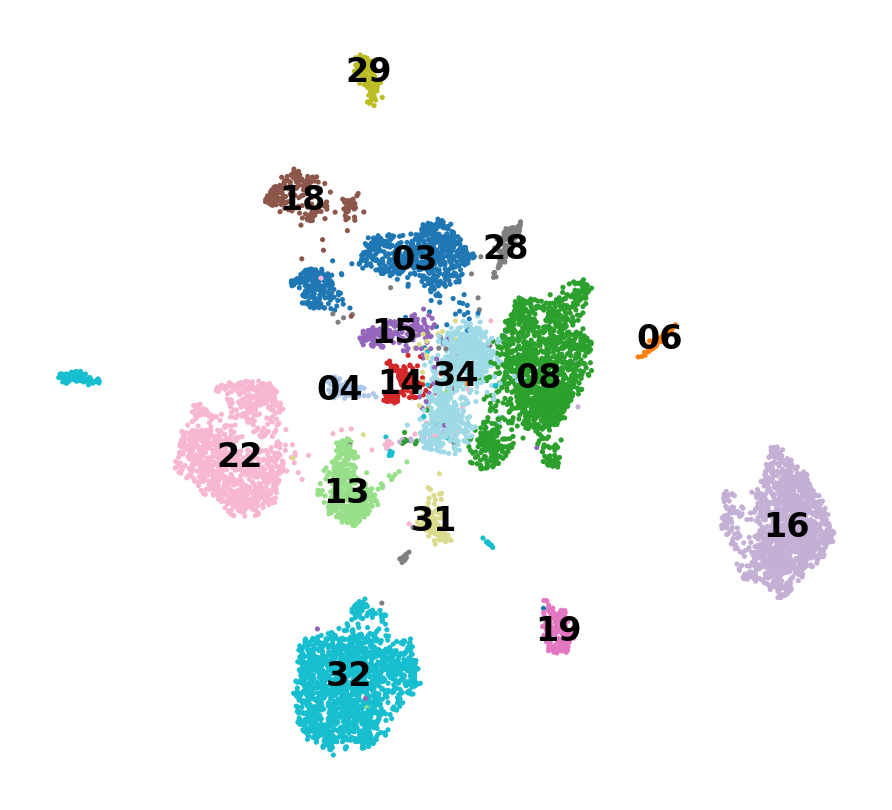

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=200)
sc.pl.umap(adata, color=['sample_num'], frameon=False, title='', legend_loc='on data', legend_fontsize=12,
           palette=color_map, ax=ax, show=False)
plt.show()

In [19]:
data_dir = '/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out'
adc_scc_scores = pd.read_csv(f'{data_dir}/ADC_SCC_scores.csv', index_col=0)

In [20]:
adc_genes = ['KRT7', 'NAPSA', 'NKX2-1', 'SFTA3', 'MUC1', 'TMC5', 'LMO3']
scc_genes = ['KRT5', 'KRT6A', 'DSG3', 'CLCA2', 'JAG1', 'TP63']

In [21]:
from scipy.stats import linregress, pearsonr
adc_scores_2 = rna_cluster_pseudobulks_normed[adc_genes].mean(axis=1)
scc_scores_2 = rna_cluster_pseudobulks_normed[scc_genes].mean(axis=1)
adc_scc_scores_2 = pd.DataFrame({'adc_score': adc_scores_2, 'scc_score': scc_scores_2})

xcol = 'scc_score'
ycol = 'adc_score'
df = adc_scc_scores_2

x = df[xcol].to_numpy()
y = df[ycol].to_numpy()

# 1) Fit y = a + b x
lr = linregress(x, y)
a, b = lr.intercept, lr.slope

# 3) Project each point p onto the line defined by point p_ref and direction v=[1, b]
v = np.array([1.0, b])
u = v / np.linalg.norm(v)                  # unit direction along the line
x0 = x.mean()
p_ref = np.array([x0, a + b*x0])           # any point on the line works; use mean-x anchor
P = np.column_stack([x, y])
t = (P - p_ref) @ u                        # signed distance along the line
P_proj = p_ref + np.outer(t, u)            # projected points on the line

# 4) Normalize to 0–1
tmin, tmax = t.min(), t.max()
scores = np.zeros_like(t) if tmax == tmin else (t - tmin) / (tmax - tmin)

adc_scc_scores_2['adc_scc_score'] = scores

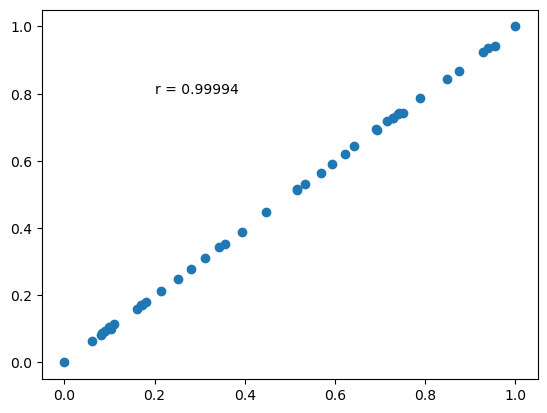

In [22]:
x = adc_scc_scores['proj_param']
y = adc_scc_scores_2['adc_scc_score']
plt.scatter(x, y)
plt.text(0.2, 0.8, f'r = {pearsonr(x, y)[0]:.5}')
plt.show()

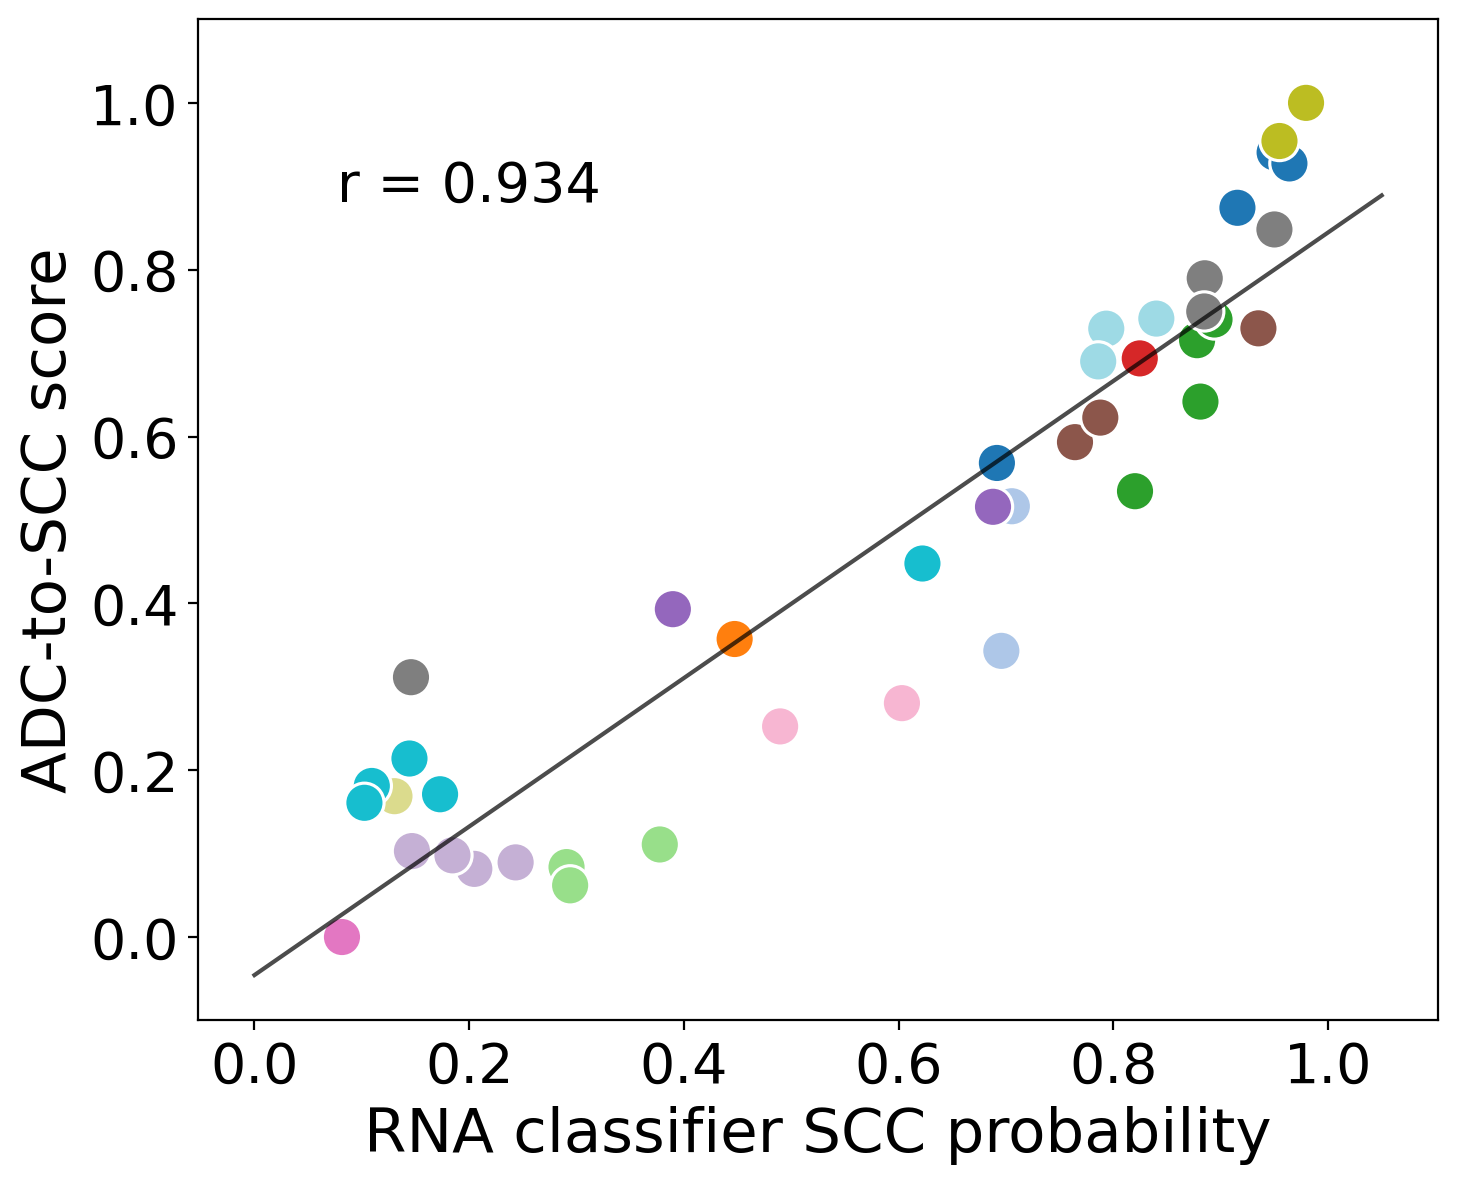

In [23]:
adc_scc_scores['RNA_classifier_SCC_prob'] = rna_cluster_pseudobulk_probs[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6.5), dpi=200)
ax.set_ylim(-0.1, 1.1)
scatterplot(
    adc_scc_scores,
    x_name='RNA_classifier_SCC_prob',
    y_name='proj_param',
    palette=color_map,
    ax=ax,
    #plot_texts=True,
    text_fontsize=15,
    adjust_text_expand=(1.25, 1.5),
    force_text=(0.5, 0.4),
    force_pull=(0.03, 0.03),
    force_static=(0.2, 0.3),
    force_explode=(0.4, 0.5),
    s=200
)
ax.get_legend().remove()
ax.set_xlabel('RNA classifier SCC probability', fontsize=22)
ax.set_ylabel('ADC-to-SCC score', fontsize=22)
ax.tick_params(axis='both', labelsize=20)

x = adc_scc_scores['RNA_classifier_SCC_prob']
y = adc_scc_scores['proj_param']

w, b = np.linalg.lstsq(np.vstack((x, np.ones(len(x)))).T, y, rcond=None)[0]
r = pearsonr(x, y)[0]

x = np.array([0, 1.05])
ax.plot(x, x*w + b, color='k', alpha=0.7)
ax.text(0.2, 0.9, f'r = {r:.3f}', ha='center', va='center', fontsize=20)

plt.show()

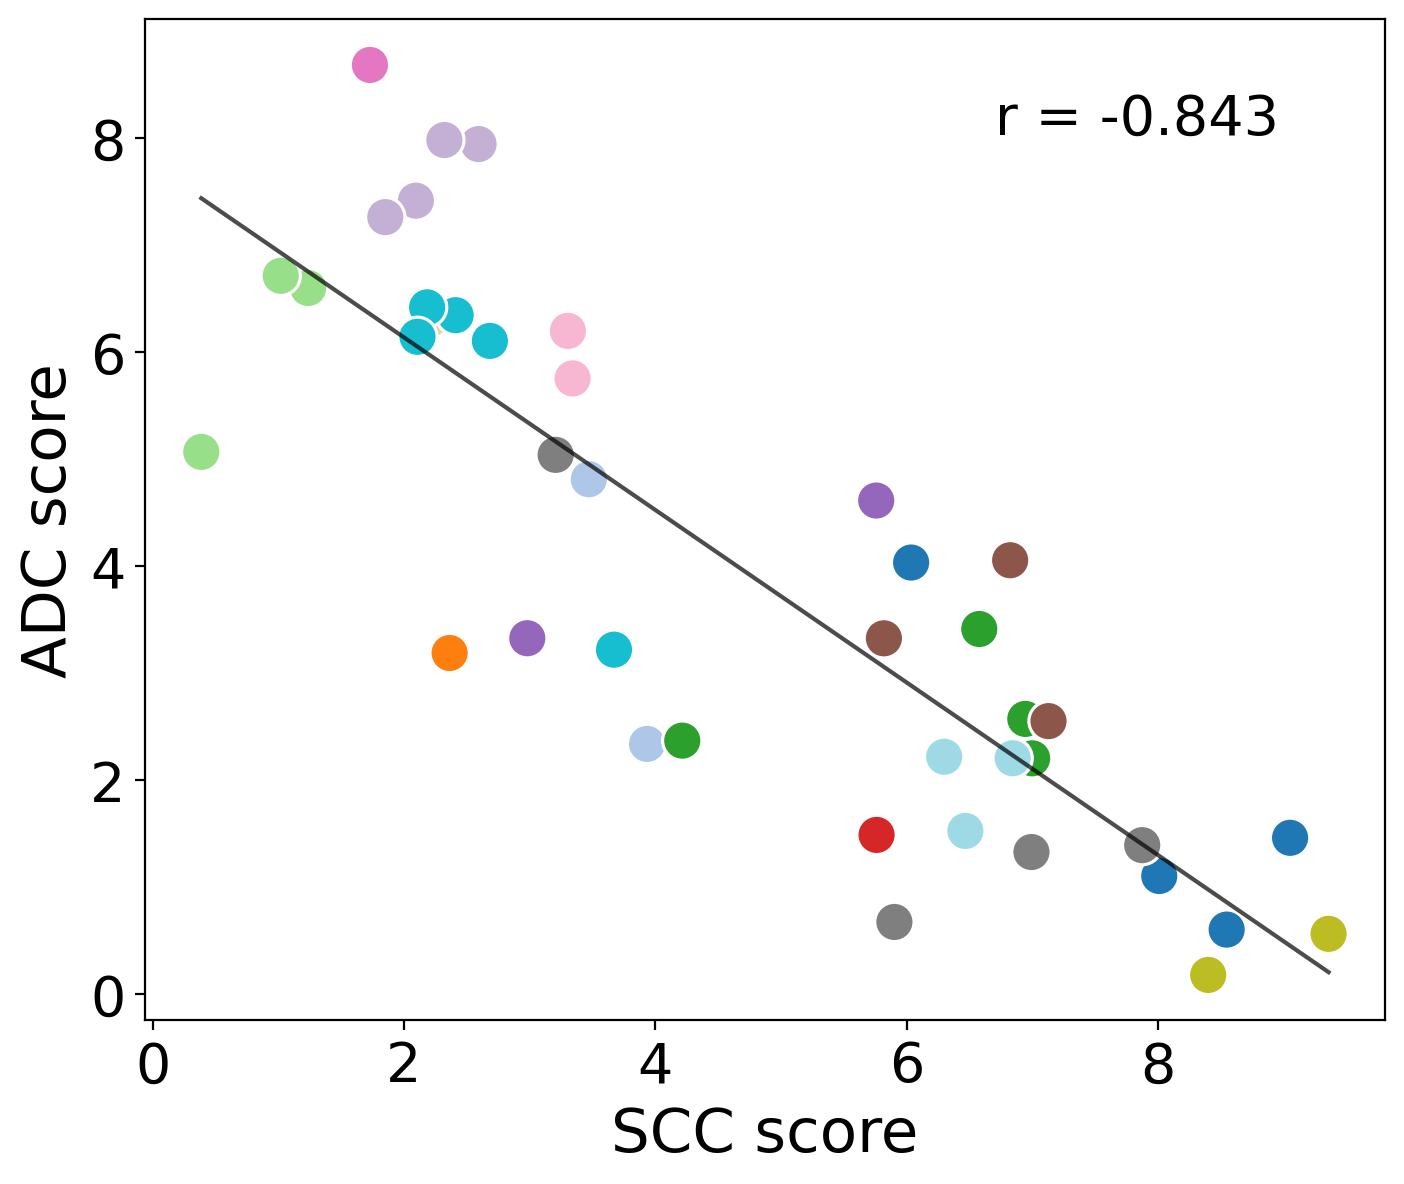

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6.5), dpi=200)
scatterplot(
    adc_scc_scores,
    x_name='squam_score',
    y_name='adeno_score',
    #hue='proj_param',
    palette=color_map,
    ax=ax,
    #plot_texts=True,
    text_fontsize=15,
    adjust_text_expand=(1.25, 1.5),
    force_text=(0.5, 0.4),
    force_pull=(0.03, 0.03),
    force_static=(0.2, 0.5),
    force_explode=(0.4, 0.5),
    s=200
)
ax.get_legend().remove()
ax.set_xlabel('SCC score', fontsize=22)
ax.set_ylabel('ADC score', fontsize=22)
ax.tick_params(axis='both', labelsize=20)

# You need to get the ScalarMappable object from the scatterplot for the colorbar
# norm = plt.Normalize(adc_scc_scores['proj_param'].min(), adc_scc_scores['proj_param'].max())
# sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
# sm.set_array([]) # Required for older Matplotlib versions

# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('ADC-to-SCC score')

x = adc_scc_scores['squam_score']
y = adc_scc_scores['adeno_score']

w, b = np.linalg.lstsq(np.vstack((x, np.ones(len(x)))).T, y, rcond=None)[0]
r = pearsonr(x, y)[0]

z = np.array([min(x), max(x)])
ax.plot(z, z*w + b, color='k', alpha=0.7)
ax.text(0.8, 0.9, f'r = {r:.3f}', ha='center', va='center', fontsize=20, transform=ax.transAxes)

plt.show()

In [25]:
import snapatac2 as snap
all_peaks = atac_model.feature_names_in_

In [26]:
import shap
data_dir = '/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out'
tcga_data = pyreadr.read_r(f'{data_dir}/tcga_log2cpm_jointTMMwsp.rds')[None]
adata = sc.AnnData(tcga_data.T)
adata.obs['cancer_type'] = [s.split('_')[0] for s in adata.obs_names]
cancer_types = ['LUAD', 'LUSC']
adata = adata[adata.obs['cancer_type'].isin(cancer_types)]
print('adata.shape', adata.shape)

adata.shape (76, 562709)


In [27]:
adata = adata[:, peaks]
print('adata.shape', adata.shape)

adata.shape (76, 50000)


In [28]:
tcga_X = adata.to_df()

In [29]:
def choose_inds_from_type(adata, ctype, k):
    inds = np.where((adata.obs['cancer_type'] == ctype).values)[0]
    return np.random.choice(inds, k, replace=False)
coef, intercept = atac_model.coef_[0], atac_model.intercept_[0]
#le = shap.LinearExplainer((coef, intercept), masker=tcga_X)
X = subset_peaks(atac_cluster_pseudobulks_normed, peaks)
le = shap.LinearExplainer((coef, intercept), masker=X)
luad_inds = choose_inds_from_type(adata, 'LUAD', 5)
lusc_inds = choose_inds_from_type(adata, 'LUSC', 5)
inds = np.concatenate((luad_inds, lusc_inds))
X = np.concatenate((X, tcga_X.iloc[inds]))
shap_vals = le.shap_values(X)

In [ ]:
shap_vals_sum = shap_vals.sum(axis=1)
(shap_vals_sum[:len(atac_cluster_pseudobulks_normed)],
 shap_vals_sum[len(atac_cluster_pseudobulks_normed):]
)

(array([ 1.57586748, -0.79265183,  2.17980504,  2.89022075,  1.83852906,
         3.47524482, -1.39225017, -2.21082694, -1.01223919, -0.54719311,
        -0.95852962, -1.23333809,  0.73275639,  1.24246129,  2.9103574 ,
         1.32644222,  0.0111214 , -5.96126107, -5.0968282 , -1.3246714 ,
        -1.89543694, -0.42986167,  1.72348031,  0.53254419, -5.34506821,
        -2.29904113, -0.5219803 ,  2.22617769,  2.95424509,  2.67543192,
        -0.10540456,  2.92195527,  3.06888005, -4.14433641, -3.59378149,
        -2.7529044 , -0.74948073,  0.67772804, -0.58999704,  2.0763041 ,
         2.36591394,  3.55161606]),
 array([-4.76468654, -5.21730117, -5.26372632, -8.06479798, -2.57218109,
         4.36256216,  4.51178749,  4.27816978,  5.30456704,  6.88590527]))

In [37]:
scc_inds = np.where(atac_cluster_pseudobulk_probs[:, 1] > 0.5)[0]
scc_shap_vals = shap_vals[scc_inds].mean(axis=0)
scc_shap_vals = scc_shap_vals * ((coef > 0) & (scc_shap_vals > 0))

adc_inds = np.where(atac_cluster_pseudobulk_probs[:, 0] > 0.5)[0]
adc_shap_vals = shap_vals[adc_inds].mean(axis=0)
adc_shap_vals = adc_shap_vals * ((coef < 0) & (adc_shap_vals < 0))

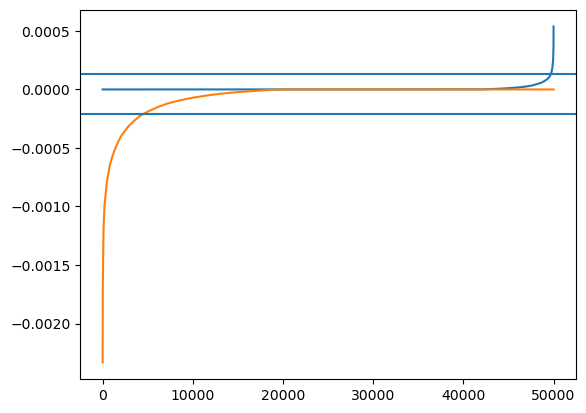

In [42]:
def plot(x):
    plt.plot(range(len(x)), x)
plot(np.sort(scc_shap_vals))
plot(np.sort(adc_shap_vals))
plt.axhline(0.00013)
plt.axhline(-0.00021)
plt.show()

In [43]:
peak_dict = {
    'adc_peaks': list(peaks[adc_shap_vals < -0.00021]),
    'scc_peaks': list(peaks[scc_shap_vals > 0.00013])
}
for k, v in peak_dict.items():
    print(k, len(v))

adc_peaks 4503
scc_peaks 312


In [44]:
%%time
motifs = snap.tl.motif_enrichment(
    motifs=snap.datasets.Meuleman_2020(),
    #motifs=snap.datasets.cis_bp(),
    regions=peak_dict,
    background=peaks,
    genome_fasta=snap.genome.hg38
)

2025-09-25 15:04:10 - INFO - Fetching 50000 sequences ...
2025-09-25 15:04:12 - INFO - Computing enrichment ...
100%|██████████| 1819/1819 [03:59<00:00,  7.59it/s]

CPU times: user 1h 49min 31s, sys: 1min 55s, total: 1h 51min 27s
Wall time: 4min 1s


In [ ]:
def get_sig_peaks(motifs_pl):
    motifs_df = motifs_pl.to_pandas()
    return motifs_df[(motifs_df['adjusted p-value'] < 0.01) &
                     (motifs_df['log2(fold change)'] > 0.3)]

def get_family_reps(motifs_df, sort_by, ascending=False, k=3):
    gb = motifs_df.groupby('family')
    dd = gb.apply(lambda x: x.sort_values(sort_by, ascending=ascending).iloc[:k])
    return dd
scc_motifs = get_sig_peaks(motifs['scc_peaks'])
adc_motifs = get_sig_peaks(motifs['adc_peaks'])

In [164]:
scc_motifs

,id,name,family,log2(fold change),p-value,adjusted p-value
227,P53_HUMAN.H11MO.0.A+257,P53,257,2.357886,0.000000e+00,0.000000e+00
228,P63_HUMAN.H11MO.0.A+257,P63,257,2.848705,0.000000e+00,0.000000e+00
229,P73_HUMAN.H11MO.0.A+257,P73,257,2.576717,0.000000e+00,0.000000e+00
835,TP63_MA0525.2+257,TP63,257,2.335554,8.405499e-13,2.184229e-10
836,TP53_MA0106.3+257,TP53,257,2.086569,2.240458e-10,4.528214e-08
837,TP73_MA0861.1+257,TP73,257,2.630930,0.000000e+00,0.000000e+00
1768,Tp53.mouse_p53l_3+257,Tp53.mouse,257,2.086569,2.240458e-10,4.528214e-08
1769,TP63_p53l_1+257,TP63,257,2.335554,8.405499e-13,2.184229e-10
1770,Tp73.mouse_p53l_1+257,Tp73.mouse,257,2.630930,0.000000e+00,0.000000e+00


In [ ]:
rename = {'AP2A': 'TFAP2A', 'AP2C': 'TFAP2C', 'COT1': 'MAP3K8', 'ERR1': 'ESRRA', 'ERR2': 'ESRRB',
          'GCR': 'NR3C1', 'NF2L2': 'NFE2L2', 'STF1': 'NR5A1', 'SRBP2': 'SREBF2', 'ZBT17': 'ZBTB17',
          'ZSC22': 'ZSCAN22', 'ZSC31': 'ZSCAN31', 'ZN263': 'ZNF263', 'ZN281': 'ZNF281',
          'ZN320': 'ZNF320', 'ZN322': 'ZNF322', 'ZN331': 'ZNF331', 'ZN341': 'ZNF341',
          'ZN436': 'ZNF436', 'ZN449': 'ZNF449', 'ZN467': 'ZNF467', 'ZN554': 'ZNF554',
          'ZN667': 'ZNF667', 'ZN770': 'ZNF770'}
def apply_rename(x):
    if x not in rename:
        return x
    return rename[x]
adc_motifs_renamed = adc_motifs.copy()
adc_motifs_renamed['name'] = adc_motifs_renamed['name'].apply(apply_rename)
mean_exp_val = np.mean(rna_cluster_pseudobulks_normed.values.flatten())
adc_motif_tfs = adc_motifs_renamed['name'].unique()
adc_motif_tfs = np.intersect1d(adc_motif_tfs, rna_cluster_pseudobulks_normed.columns)
adc_motif_tf_exp = rna_cluster_pseudobulks_normed.iloc[adc_inds][adc_motif_tfs]
keep_tfs_mask = adc_motif_tf_exp.mean(axis=0) > mean_exp_val
kept_tfs = keep_tfs_mask[keep_tfs_mask].index
print(f'{len(keep_tfs_mask) - len(kept_tfs)} tfs removed due to low expression, {len(kept_tfs)} left')
adc_motifs_expressed = adc_motifs_renamed[adc_motifs_renamed['name'].isin(kept_tfs)]
adc_motifs_expressed['expression'] = adc_motifs_expressed['name'].map(adc_motif_tf_exp.mean(axis=0))

In [165]:
rename = {'P53': 'TP53', 'P63': 'TP63', 'P73': 'TP73'}
def apply_rename(x):
    if x not in rename:
        return x
    return rename[x]
scc_motifs_renamed = scc_motifs.copy()
scc_motifs_renamed['name'] = scc_motifs_renamed['name'].apply(apply_rename)
mean_exp_val = np.mean(rna_cluster_pseudobulks_normed.values.flatten())
scc_motif_tfs = scc_motifs_renamed['name'].unique()
scc_motif_tfs = np.intersect1d(scc_motif_tfs, rna_cluster_pseudobulks_normed.columns)
scc_motif_tf_exp = rna_cluster_pseudobulks_normed.iloc[scc_inds][scc_motif_tfs]
keep_tfs_mask = scc_motif_tf_exp.mean(axis=0) > mean_exp_val
kept_tfs = keep_tfs_mask[keep_tfs_mask].index
print(f'{len(keep_tfs_mask) - len(kept_tfs)} tfs removed due to low expression, {len(kept_tfs)} left')
scc_motifs_expressed = scc_motifs_renamed[scc_motifs_renamed['name'].isin(kept_tfs)]
scc_motifs_expressed['expression'] = scc_motifs_expressed['name'].map(scc_motif_tf_exp.mean(axis=0))

0 tfs removed due to low expression, 3 left


/tmp/ipykernel_2255537/182535973.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scc_motifs_expressed['expression'] = scc_motifs_expressed['name'].map(scc_motif_tf_exp.mean(axis=0))


In [166]:
scc_motifs_expressed

,id,name,family,log2(fold change),p-value,adjusted p-value,expression
227,P53_HUMAN.H11MO.0.A+257,TP53,257,2.357886,0.000000e+00,0.000000e+00,4.143126
228,P63_HUMAN.H11MO.0.A+257,TP63,257,2.848705,0.000000e+00,0.000000e+00,7.436530
229,P73_HUMAN.H11MO.0.A+257,TP73,257,2.576717,0.000000e+00,0.000000e+00,3.125459
835,TP63_MA0525.2+257,TP63,257,2.335554,8.405499e-13,2.184229e-10,7.436530
836,TP53_MA0106.3+257,TP53,257,2.086569,2.240458e-10,4.528214e-08,4.143126
837,TP73_MA0861.1+257,TP73,257,2.630930,0.000000e+00,0.000000e+00,3.125459
1769,TP63_p53l_1+257,TP63,257,2.335554,8.405499e-13,2.184229e-10,7.436530


In [ ]:
adc_motifs_to_plot = [
    'KLF5_HUMAN.H11MO.0.A+109', 'BACH1_HUMAN.H11MO.0.A+53', 'ZN770_HUMAN.H11MO.0.C+113'
]

In [ ]:
get_family_reps(adc_motifs_expressed, sort_by='expression', k=2, ascending=False).sort_values(by='adjusted p-value').head(30)

id    name family  log2(fold change)  \
family                                                                    
113    166    MAZ_HUMAN.H11MO.0.A+113     MAZ    113           0.437381   
54     80    FOSL1_HUMAN.H11MO.0.A+54   FOSL1     54           1.202047   
       79     FOSB_HUMAN.H11MO.0.A+54    FOSB     54           1.058651   
53     17    BACH2_HUMAN.H11MO.0.A+53   BACH2     53           0.823751   
54     81    FOSL2_HUMAN.H11MO.0.A+54   FOSL2     54           1.088773   
53     16    BACH1_HUMAN.H11MO.0.A+53   BACH1     53           0.849578   
113    360  ZN263_HUMAN.H11MO.0.A+113  ZNF263    113           0.452456   
       370  ZN341_HUMAN.H11MO.0.C+113  ZNF341    113           0.406551   
53     189   NF2L2_HUMAN.H11MO.0.A+53  NFE2L2     53           0.670416   
265    41    CTCF_HUMAN.H11MO.0.A+265    CTCF    265           0.823052   

                 p-value  adjusted p-value  expression  
family                                                  
113    166  0.000000e+00      0.000000e+00    2.948518  
54     80   0.000000e+00      0.000000e+00    3.050220  
       79   0.000000e+00      0.000000e+00    4.197356  
53     17   0.000000e+00      0.000000e+00    4.307719  
54     81   0.000000e+00      0.000000e+00    7.536023  
53     16   0.000000e+00      0.000000e+00    7.989820  
113    360  2.220446e-15      6.310924e-14    4.329308  
       370  3.663736e-15      1.009748e-13    4.002920  
53     189  5.884182e-15      1.551207e-13    8.297962  
265    41   2.665612e-11      5.841866e-10    6.489355

In [137]:
def load_pwm(path):
    with open(path) as f:
        lines = [line.strip() for line in f if not line.startswith(">")]
    pwm = np.array([[float(x) for x in line.split()] for line in lines])
    return pwm

pwm = load_pwm("/data1/chanj3/shared/motifs/HOCOMOCO_v11/pwm/INSM1_HUMAN.H11MO.0.C.pwm")
print(pwm.shape)  # (length, 4)

(12, 4)


In [138]:
def pwm_to_probs(pwm):
    probs = np.exp(pwm)
    probs = probs / probs.sum(axis=1, keepdims=True)
    return probs

probs = pwm_to_probs(pwm)

/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff207d5e380>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff207d51480>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff207d5

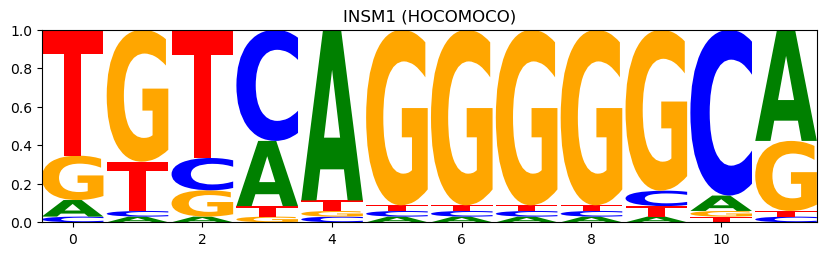

In [139]:
import logomaker
def plot_motif(probs, title="Motif"):
    df = pd.DataFrame(
        probs,
        columns=["A", "C", "G", "T"]
    )
    logo = logomaker.Logo(df, color_scheme="classic")
    plt.title(title)
    plt.show()

plot_motif(probs, title="INSM1 (HOCOMOCO)")

In [143]:
def probs_to_bits_df(probs, background=None):
    """
    Convert per-position probabilities to information-content matrix (bits logo).
    Height of letter b at pos i = p(b,i) * IC(i), where IC(i)=log2(4)-H(p_i) (for DNA).
    background (optional): dict like {'A':0.25,'C':0.25,'G':0.25,'T':0.25}
    If provided, uses small-sample correction from logomaker’s transform (Schneider & Stephens style).
    """
    df = pd.DataFrame(probs, columns=['A','C','G','T'])
    if background is None:
        # classic bits logo: IC(i) = 2 - H(p_i), H base 2
        eps = 1e-12
        P = np.clip(probs, eps, 1.0)
        H = -(P * (np.log(P)/np.log(2))).sum(axis=1)  # per-position entropy
        IC = 2.0 - H  # for DNA (log2(4)=2)
        df_bits = df.mul(IC, axis=0)
    else:
        # use logomaker’s background-aware transform
        df_bits = logomaker.transform_matrix(
            df.copy(),
            from_type='probability',
            to_type='information',
            background=background
        )
    return df_bits

def load_motif_matrix(basename, pwm_dir, mode='prob', background=None):
    """
    basename: like 'INSM1_HUMAN.H11MO.0.C' (no suffix, no '.pwm')
    mode: 'prob' -> probabilities; 'bits' -> information-content
    """
    path = os.path.join(pwm_dir, f"{basename}.pwm")
    pwm = load_pwm(path)
    probs = pwm_to_probs(pwm)
    if mode == 'prob':
        return pd.DataFrame(probs, columns=['A','C','G','T'])
    elif mode == 'bits':
        return probs_to_bits_df(probs, background=background)
    else:
        raise ValueError("mode must be 'prob' or 'bits'")

/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff1a2db4eb0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff19a9a17e0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff19a9a

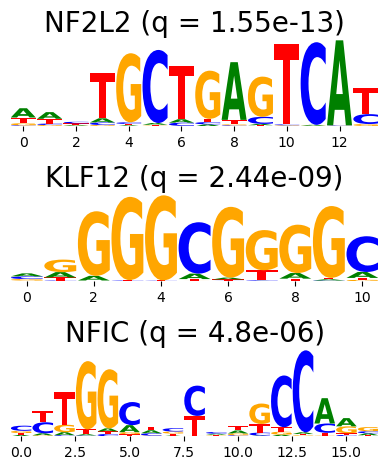

In [170]:
import re
def snap_name_to_hocomoco_basename(name):
    """
    SnapATAC2 sometimes appends '+<family>' to HOCOMOCO ids (e.g., 'FOSL1_HUMAN.H11MO.0.A+54').
    Strip anything from '+' onward so it matches the HOCOMOCO filename.
    """
    return re.split(r'\+', name)[0]
# ---------- plotting ----------
def plot_motifs_grid(
    motif_names,
    pwm_dir,
    mode='bits',                    # 'bits' (information content) or 'prob'
    background=None,                # e.g., {'A':.25,'C':.25,'G':.25,'T':.25}
    ncols=3,
    figsize_per_panel=(4, 1.6),     # width, height per subplot
    title_sanitize=True,
    tight=True,
    qvals=None
):
    """
    motif_names: list of names that may include '+family' (e.g., 'FOSL1_HUMAN.H11MO.0.A+54').
    """
    # prepare grid
    N = len(motif_names)
    ncols = max(1, ncols)
    nrows = (N + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_per_panel[0]*ncols,
                                                                figsize_per_panel[1]*nrows),
                             squeeze=False)

    for i, raw in enumerate(motif_names):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        basename = snap_name_to_hocomoco_basename(raw)
        try:
            mat = load_motif_matrix(basename, pwm_dir, mode=mode, background=background)
            logo = logomaker.Logo(mat, ax=ax)
            # aesthetics
            ax.set_yticks([])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            title = basename if not title_sanitize else basename.split('_HUMAN')[0]
            if qvals is not None:
                title = f'{title} (q = {qvals[i]:.3})'
            ax.set_title(title, fontsize=20)
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed:\n{basename}\n{e}", ha='center', va='center')
            ax.axis('off')

    # hide any empty panels
    for j in range(N, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis('off')

    if tight:
        plt.tight_layout()
    return fig

pwm_dir = "/data1/chanj3/shared/motifs/HOCOMOCO_v11/pwm"
adc_motif_qvals = adc_motifs_expressed.set_index('id').loc[adc_motifs_to_plot]['adjusted p-value'].values
# 1) Information-content logos (classic uniform background)
plot_motifs_grid(
    adc_motifs_to_plot,
    pwm_dir,
    mode='bits',
    background=None,  # or {'A':.25,'C':.25,'G':.25,'T':.25}
    ncols=1,
    qvals=adc_motif_qvals
)
plt.show()

#
# # 2) Probability logos (heights = probabilities)
# plot_motifs_grid(
#     enriched_names,
#     pwm_dir,
#     mode='prob',
#     ncols=3
# )
# plt.show()

In [168]:
scc_motifs_to_plot = ['P63_HUMAN.H11MO.0.A+257']

/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff19bddece0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff199b97700>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7ff19bdd

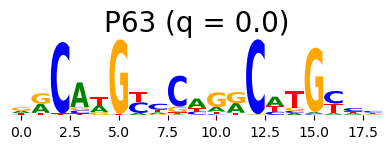

In [171]:
scc_motif_qvals = scc_motifs.set_index('id').loc[scc_motifs_to_plot]['adjusted p-value'].values
plot_motifs_grid(
    scc_motifs_to_plot,
    pwm_dir,
    mode='bits',
    background=None,  # or {'A':.25,'C':.25,'G':.25,'T':.25}
    ncols=1,
    qvals=scc_motif_qvals
)
plt.show()

# RNA feature importance

In [174]:
# compare to predictions on TCGA data
tcga_em_dir = '/data1/chanj3/LUAS.multiome.results/TCGA_expression_modeling'
exp_data = pd.read_csv(f'{tcga_em_dir}/data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena', sep='\t')
exp_data = exp_data[~exp_data.iloc[:, 0].str[0].str.isdigit()]
exp_data = exp_data.fillna(0)
exp_data = exp_data.set_index('sample')

clinical_data = pd.read_csv(f'{tcga_em_dir}/data/Survival_SupplementalTable_S1_20171025_xena_sp', sep='\t')
clinical_data.head()

sample_to_cancertype = clinical_data[['sample', 'cancer type abbreviation']].set_index('sample').iloc[:, 0].to_dict()
exp_data = exp_data.iloc[:, exp_data.columns.isin(list(sample_to_cancertype.keys()))]
print(exp_data.shape)
cancertype_labels = [sample_to_cancertype[sample] for sample in exp_data.columns]
adata = sc.AnnData(exp_data.T)
adata = adata[:, np.unique(adata.var_names, return_index=True)[1]]
adata.obs['cancer_type'] = cancertype_labels
cancer_types = [
    'PRAD',
    'LUAD',
    'BLCA',
    'UCEC',
    'COAD',
    'TGCT',
    'LUSC',
    'THCA',
    'PCPG',
    'SKCM',
    'BRCA',
    'GBM',
    'LIHC',
    'ACC',
    'KIRC',
    'MESO',
    'STAD',
    'OV',
]
cancer_types = ['LUAD', 'LUSC']
adata = adata[adata.obs['cancer_type'].isin(cancer_types)]

(20502, 11014)


/home/yangf4/envs/SnapATAC2/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_2255537/779046105.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cancer_type'] = cancertype_labels


In [176]:
tcga_X = adata[:, genes].to_df()

In [177]:
def choose_inds_from_type(adata, ctype, k):
    inds = np.where((adata.obs['cancer_type'] == ctype).values)[0]
    return np.random.choice(inds, k, replace=False)
coef, intercept = rna_model.coef_[0], rna_model.intercept_[0]
#le = shap.LinearExplainer((coef, intercept), masker=tcga_X)
X = subset_peaks(rna_cluster_pseudobulks_normed, genes)
le = shap.LinearExplainer((coef, intercept), masker=X)
luad_inds = choose_inds_from_type(adata, 'LUAD', 5)
lusc_inds = choose_inds_from_type(adata, 'LUSC', 5)
inds = np.concatenate((luad_inds, lusc_inds))
X = np.concatenate((X, tcga_X.iloc[inds]))
shap_vals = le.shap_values(X)

In [179]:
shap_vals_sum = shap_vals.sum(axis=1)
(shap_vals_sum[:len(atac_cluster_pseudobulks_normed)],
 shap_vals_sum[len(atac_cluster_pseudobulks_normed):]
)

(array([ 2.40207624,  0.25940186,  2.74076703,  1.83624371,  0.27888394,
         0.325472  , -0.75970846,  1.42600763,  1.58699109,  1.45542238,
         0.96973243, -1.44001654, -1.04798498, -1.42380252,  1.00009273,
         0.24245326, -0.99650318, -2.30864121, -1.90461431, -2.03457594,
        -1.6827899 ,  0.62835205,  2.12073206,  0.76421936, -2.96957675,
        -0.589495  , -0.12965146,  1.49421153,  1.48975148,  2.39803707,
        -2.31579942,  3.3201525 ,  2.50192547, -2.44519659, -2.6457348 ,
        -2.71824222, -2.11322061, -0.04916434, -2.32724751,  0.79776683,
         1.11078466,  0.7524884 ]),
 array([-2.92122535, -4.92617029, -4.30611694, -1.40804413, -4.99097698,
         4.99606142,  2.28060659,  0.85215306,  2.89505339,  3.91415877]))

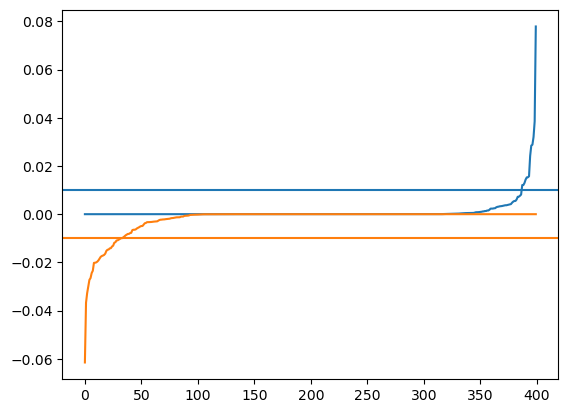

In [184]:
scc_inds = np.where(atac_cluster_pseudobulk_probs[:, 1] > 0.5)[0]
scc_shap_vals = shap_vals[scc_inds].mean(axis=0)
scc_shap_vals = scc_shap_vals * ((coef > 0) & (scc_shap_vals > 0))

adc_inds = np.where(atac_cluster_pseudobulk_probs[:, 0] > 0.5)[0]
adc_shap_vals = shap_vals[adc_inds].mean(axis=0)
adc_shap_vals = adc_shap_vals * ((coef < 0) & (adc_shap_vals < 0))
def plot(x):
    plt.plot(range(len(x)), x)
plot(np.sort(scc_shap_vals))
plot(np.sort(adc_shap_vals))
plt.axhline(0.01)
plt.axhline(-0.01, color='C1')
plt.show()

In [188]:
k = 30
order = np.argsort(scc_shap_vals)[::-1]
for i in range(k):
    print(i, genes[order[i]], scc_shap_vals[order[i]])

0 KRT5 0.07791845354340896
1 DSG3 0.038561967202816086
2 KRT14 0.03204382916932068
3 KRT6A 0.028827417503684873
4 DSC3 0.028494999870615826
5 CLCA2 0.02418307855283095
6 NKAIN2 0.015737554332583167
7 CALML3 0.015314340789818111
8 ADAM23 0.015269715681392225
9 SERPINB13 0.014389184482118835
10 PTHLH 0.012970526178646273
11 NTRK2 0.012107320796499618
12 KRT6B 0.0120969985472551
13 PNCK 0.008145719690493809
14 CSTA 0.0076598938221104215
15 SLCO1A2 0.0072774717897466845
16 MAGEA4 0.007211352174531591
17 BMP7 0.006082933496529327
18 S100A7 0.005487846984666085
19 ADH7 0.005482971348997453
20 CDHR1 0.005206614219824184
21 VSNL1 0.004774001634326289
22 TRIM29 0.0041888765840584685
23 SERPINB3 0.004039677182293499
24 FGFBP1 0.003919572634495861
25 DAPL1 0.00382056804975299
26 SERPINB4 0.003709316373370992
27 TMEM40 0.003706022552445139
28 KRT13 0.003569494563366694
29 KRT6C 0.0034797247124766614


In [189]:
k = 30
order = np.argsort(adc_shap_vals)
for i in range(k):
    print(i, genes[order[i]], adc_shap_vals[order[i]])

0 MUC5B -0.061553690611947515
1 PLA2G10 -0.03674580943835294
2 SORBS2 -0.03276328640511594
3 MSLN -0.030138428958730156
4 VSTM2L -0.027265102870218473
5 MUC21 -0.026508316725209816
6 MUC1 -0.024431353109603315
7 LGSN -0.023478863047369153
8 BCL2L15 -0.020210218230226833
9 KCNQ3 -0.020149108757581496
10 AGR2 -0.020010851417035555
11 SLC44A4 -0.01968317310181571
12 MUC13 -0.01916000682901277
13 HKDC1 -0.018403291969509385
14 SPINK1 -0.017692703233489523
15 HNF1B -0.017359623248743527
16 TOX3 -0.017164623277462952
17 PLEKHA6 -0.016910273111178244
18 EPHA10 -0.016383439892348063
19 TMC5 -0.01523671228766188
20 KRT7 -0.014769281027572032
21 RORC -0.014659043880398528
22 SPDEF -0.014190087116379046
23 ENPP3 -0.014097731546857725
24 PPP1R9A -0.013405015976007925
25 CEACAM5 -0.013073264969495192
26 PRR15L -0.011852899982712954
27 HAVCR1 -0.01164485723639374
28 TM4SF4 -0.010920177012580589
29 AQP5 -0.010842698650099921
